*author: Fadi Makarem*

# Data Augmentation for NLP

In this notebook I explore and implement data augmentation for natural language processing. I will go through various methods. However, increasing peformance is not the focus of this notebook.

* **[1- Install Libraries and Depenccies](#Installation)**
* **[2- Testing NLP augmentation](#TestingAug)**
    * [2.1- EDA Using Therasaurus](#therasaurus)
    * [2.2- Using Word Embeddings](#embeddings)
    * [2.3- Using Language Models Like BERT and RoBERTa](#languageModel)
    * [2.4- Back-translation](#backtranslation)
* **[3- Defining Parameters](#definitions)**
* **[4- Data Preparation and Visualization](#Data)**
    * [4.1- Data Distributions](#distributions)
    * [4.2- Vectorization](#Vectorization)
* **[5- Testing/Implementation](#testing)**
    * [5.1- No Augmentation](#noAug)
    * [5.2- With Augmentation](#WithAug)
    * [5.3- Augment Minorities Only](#augMinority)
* **[6- Conclusion](#conclusion)**

# 1- Install Libraries and Depenccies 

<a class="anchor"  id="Installation"></a>

In [1]:
!pip install nlpaug --quiet
!pip install -U sacremoses --quiet

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
# import nlpaug
import nlpaug.augmenter.word as naw
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
import os
from nlpaug.util.file.download import DownloadUtil

2024-04-15 16:39:24.393498: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-15 16:39:24.393621: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-15 16:39:24.515284: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print("We got a GPU")
    device="cuda"
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    device="cpu"
    print("Sorry, no GPU for you...")

gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

We got a GPU


# 2- Testing NLP augmentation <a class="anchor"  id="TestingAug"></a>


In this section we will implement data augmentation using NLPAug on a sample text. The interest is in word level augmentation. However, other methods can be used like character level to generate typos.

In [4]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

First we need to download stop words to prevent augmenting them. Note that, if data augmentation should be performed for very specific words only, then you can create the vocab from training set, remove the words to be augmented, and pass the list to the data augmentation methods of NLPAug.

In [5]:
nltk.download('stopwords')
stopwords_en=(stopwords.words('english'))
stopwords_en[:5]

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i', 'me', 'my', 'myself', 'we']

##### UNZIP WORDNET

In [6]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [7]:
text_example='data augmentation is interesting. lots of surprises!'

In [8]:
wordnet.synsets('dog')

[Synset('dog.n.01'),
 Synset('frump.n.01'),
 Synset('dog.n.03'),
 Synset('cad.n.01'),
 Synset('frank.n.02'),
 Synset('pawl.n.01'),
 Synset('andiron.n.01'),
 Synset('chase.v.01')]

In [9]:
# DownloadUtil.download_word2vec(dest_dir='.') # Download word2vec model
# DownloadUtil.download_glove(model_name='glove.6B', dest_dir='.') # Download GloVe model
DownloadUtil.download_fasttext(model_name='wiki-news-300d-1M', dest_dir='.') # Download fasttext model

### 2.1- EDA Using Therasaurus <a class="anchor"  id="therasaurus"></a>

The techniques to be applied are:

1. random synonym replacement
2. random word swapping
3. random word deletion


In [10]:
syn_aug = naw.SynonymAug(aug_src='wordnet', 
                         model_path=None, 
                         name='Synonym_Aug', 
                         aug_min=1, 
                         aug_max=4, 
                         aug_p=0.1, 
                         lang='eng', 
                         stopwords=stopwords_en, 
                         tokenizer=None, 
                         reverse_tokenizer=None, 
                         stopwords_regex=None, 
                         force_reload=False, 
                         verbose=0)

print(text_example)
for _ in range(5):
    example_aug = syn_aug.augment(text_example)    
    print(example_aug)

data augmentation is interesting. lots of surprises!
['data augmentation is interesting. heap of surprises!']
['data augmentation is interesting. lots of surprises!']
['data augmentation is interest. lots of surprises!']
['data augmentation is interesting. lot of surprises!']
['data augmentation is interesting. destiny of surprises!']


In [11]:
swap_aug = naw.RandomWordAug(action="swap",
                             aug_min=1, 
                             aug_max=4, 
                             aug_p=0.1,  
                             stopwords=stopwords_en
                             )

print(text_example)
for _ in range(5):
    example_aug = swap_aug.augment(text_example)    
    print(example_aug)

data augmentation is interesting. lots of surprises!
['data augmentation is interesting. lots of! surprises']
['augmentation data is interesting. lots of surprises!']
['data is augmentation interesting. lots of surprises!']
['data augmentation is interesting. of lots surprises!']
['data augmentation is interesting lots. of surprises!']


In [12]:
del_aug = naw.RandomWordAug(aug_min=1, 
                            aug_max=4, 
                            aug_p=0.1,  
                            stopwords=stopwords_en)

print(text_example)
for _ in range(5):
    example_aug = del_aug.augment(text_example)    
    print(example_aug)

data augmentation is interesting. lots of surprises!
['data is interesting. lots of surprises!']
['augmentation is interesting. lots of surprises!']
['data augmentation is interesting. of surprises!']
['data augmentation is interesting. of surprises!']
['data augmentation is interesting. of surprises!']


### 2.2- Using Word Embeddings <a class="anchor"  id="embeddings"></a>

Instead of using a fixed dictionary, we can use word embeddings like Word2Vec, GloVe, and FastText.

"action" values:
- **Insert**: randomly insert the synonym of a word in the sentence.
- **Substitute**: randomly replace a word in the sentence with its synonym.

In [13]:
emde_aug_subs = naw.WordEmbsAug(
    model_type='fasttext', 
    model_path='/kaggle/working/wiki-news-300d-1M.vec',
    aug_min=1, 
    aug_max=4, 
    aug_p=0.1, 
    stopwords=stopwords_en,
    action="substitute"
)

print(text_example)
for _ in range(5):
    example_aug = emde_aug_subs.augment(text_example)    
    print(example_aug)

data augmentation is interesting. lots of surprises!
['methodology augmentation is interesting. lots of surprises!']
['data augmentation is interesting. all of surprises!']
['data transformation is interesting. lots of surprises!']
['data augmentation is difficult. lots of surprises!']
['datas augmentation is interesting. lots of surprises!']


This technique could be very useful if trained on the data. However, using embeddings trained from other datasets will not get good results as the words are associate with irrelevant words.

### 2.3- Using Language Models Like BERT and RoBERTa <a class="anchor" id="languageModel"></a>

For this technique, instead of substituting a word with a synonym or dictionary, we use language models to generate a new word to replace it. 

- **pros:** Predicts the words taking into account the rest of the sentence unlike previous methods that only use the word embeddings or dictionary synonyms.
- **cons:** It takes more time and processing because a larger model is used (RoBERTa)

In [14]:
aug_lang_model_sub = naw.ContextualWordEmbsAug(
    model_path='roberta-base', 
    action="substitute",
    aug_min=1, 
    aug_max=4, 
    aug_p=0.1,  
    stopwords=stopwords_en,
    device=device)
# augmented_text = aug.augment(text)

print(text_example)
for _ in range(5):
    example_aug = aug_lang_model_sub.augment(text_example)
    print(example_aug)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

data augmentation is interesting. lots of surprises!
['data augmentation is accurate. End of surprises!']
['data that is new. lots of surprises!']
['data augmentation is beautiful. lots of use!']
['data this is big. lots of surprises!']
['data summary is interesting. Beware of surprises!']


In [15]:
aug_lang_model_insert = naw.ContextualWordEmbsAug(
    model_path='roberta-base', 
    action="insert",
    aug_min=1, 
    aug_max=4, 
    aug_p=0.1,  
    stopwords=stopwords_en,
    device=device)
# augmented_text = aug.augment(text)

print(text_example)
for _ in range(5):
    example_aug = aug_lang_model_insert.augment(text_example)
    print(example_aug)

data augmentation is interesting. lots of surprises!
['data column augmentation is always interesting. lots of surprises!']
['data augmentation is surprisingly interesting. lots of potential surprises!']
['data Genetic augmentation is interesting. Mostly lots of surprises!']
['data The augmentation is interesting. lots of pleasant surprises!']
['data augmentation is interesting. Hopefully lots of interesting surprises!']


### 2.4- Back-Translation <a class="anchor" id="backtranslation"/>

Last, we implement back-propagation. Essentially, we translate from use language to another, and then back to original language.

In [16]:
back_translation_aug = naw.BackTranslationAug(
    from_model_name='facebook/wmt19-en-de', 
    to_model_name='facebook/wmt19-de-en',
    device=device
)
# back_translation_aug.augment(text)

print(text_example)
example_aug = back_translation_aug.augment(text_example)
print(example_aug)

config.json:   0%|          | 0.00/825 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.08G [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of FSMTForConditionalGeneration were not initialized from the model checkpoint at facebook/wmt19-en-de and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/235 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/825 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.08G [00:00<?, ?B/s]

Some weights of FSMTForConditionalGeneration were not initialized from the model checkpoint at facebook/wmt19-de-en and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/260 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/67.0 [00:00<?, ?B/s]

vocab-src.json:   0%|          | 0.00/849k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/315k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/67.0 [00:00<?, ?B/s]

vocab-src.json:   0%|          | 0.00/849k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/315k [00:00<?, ?B/s]

data augmentation is interesting. lots of surprises!
['Data expansion is interesting. Many surprises!']


**Dictionary of augmentations used above**

In [17]:
augmentation={
    "synonym":syn_aug,
    "swap":swap_aug,
    "delete":del_aug,
    "embedding_sub":emde_aug_subs,
    "embedding_insert":aug_lang_model_insert,
    "lan_sub":aug_lang_model_sub,
    "back-translation":back_translation_aug
}

# 3- Defining Parameters <a class="anchor" id="definitions"/>

In [18]:
data_filename='/kaggle/input/emotions/text.csv'
batch_size=128
random_state=20
aug_prob=0.3
epochs=5
plt.style.use('ggplot')

run_no_aug=True
run_aug_batch=True
run_aug_min=False

label_to_meaning={
    0:'sadness',
    1:'joy',
    2:'love',
    3:'anger',
    4:'fear',
    5:'surprise'
}

# 4- Data Preparation and Visualization <a class="anchor" id="Data"/>

In [19]:
dataset=pd.read_csv(data_filename)
#only keep class 0 and 1 to avoid class imbalance
# dataset=dataset[dataset['label'].isin([0,1,2,3,4])]
dataset

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4
...,...,...,...
416804,416804,i feel like telling these horny devils to find...,2
416805,416805,i began to realize that when i was feeling agi...,3
416806,416806,i feel very curious be why previous early dawn...,5
416807,416807,i feel that becuase of the tyranical nature of...,3


In [20]:
X=dataset.index.values.tolist()
y=dataset['label'].values.tolist()
test_size=0.3
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=test_size, random_state=random_state,stratify=y)

In [21]:
train_df=dataset.loc[X_train]
test_df=dataset.loc[X_test]

### 4.1- Data Distributions <a class="anchor" id="distributions"/>

Below you can find a graph of the distribution of classes given text length. At the end, you will see the percentage of each class in the train dataset.

Examples for sadness:

im probally in the worst mood ever right now and i feel heartbroken 

i feel like im tattooed with the word damaged on my forehead 

i thought by holding back i could save some feeligns and not get totally heartbroken 

there are 84831 samples




Examples for joy:

i feel like i did so much this past weekend yet have no fabulous before and after photos to show for all my work 

i feel really is vital and what keeps me involved with the church is the notion that we should no must love one another and that our whole reason for being in the world is to do good for each other 

i feel when my girlfriend isn t satisfied with any restaurant suggestion 

there are 98747 samples




Examples for love:

i feel a need to say a very fond farewell to the pickled bean 

ive never been able to describe the feeling i get doing theatre and what makes me so passionate about it but this book really does explain it really well 

i say his helpless the phone muttered the i love you

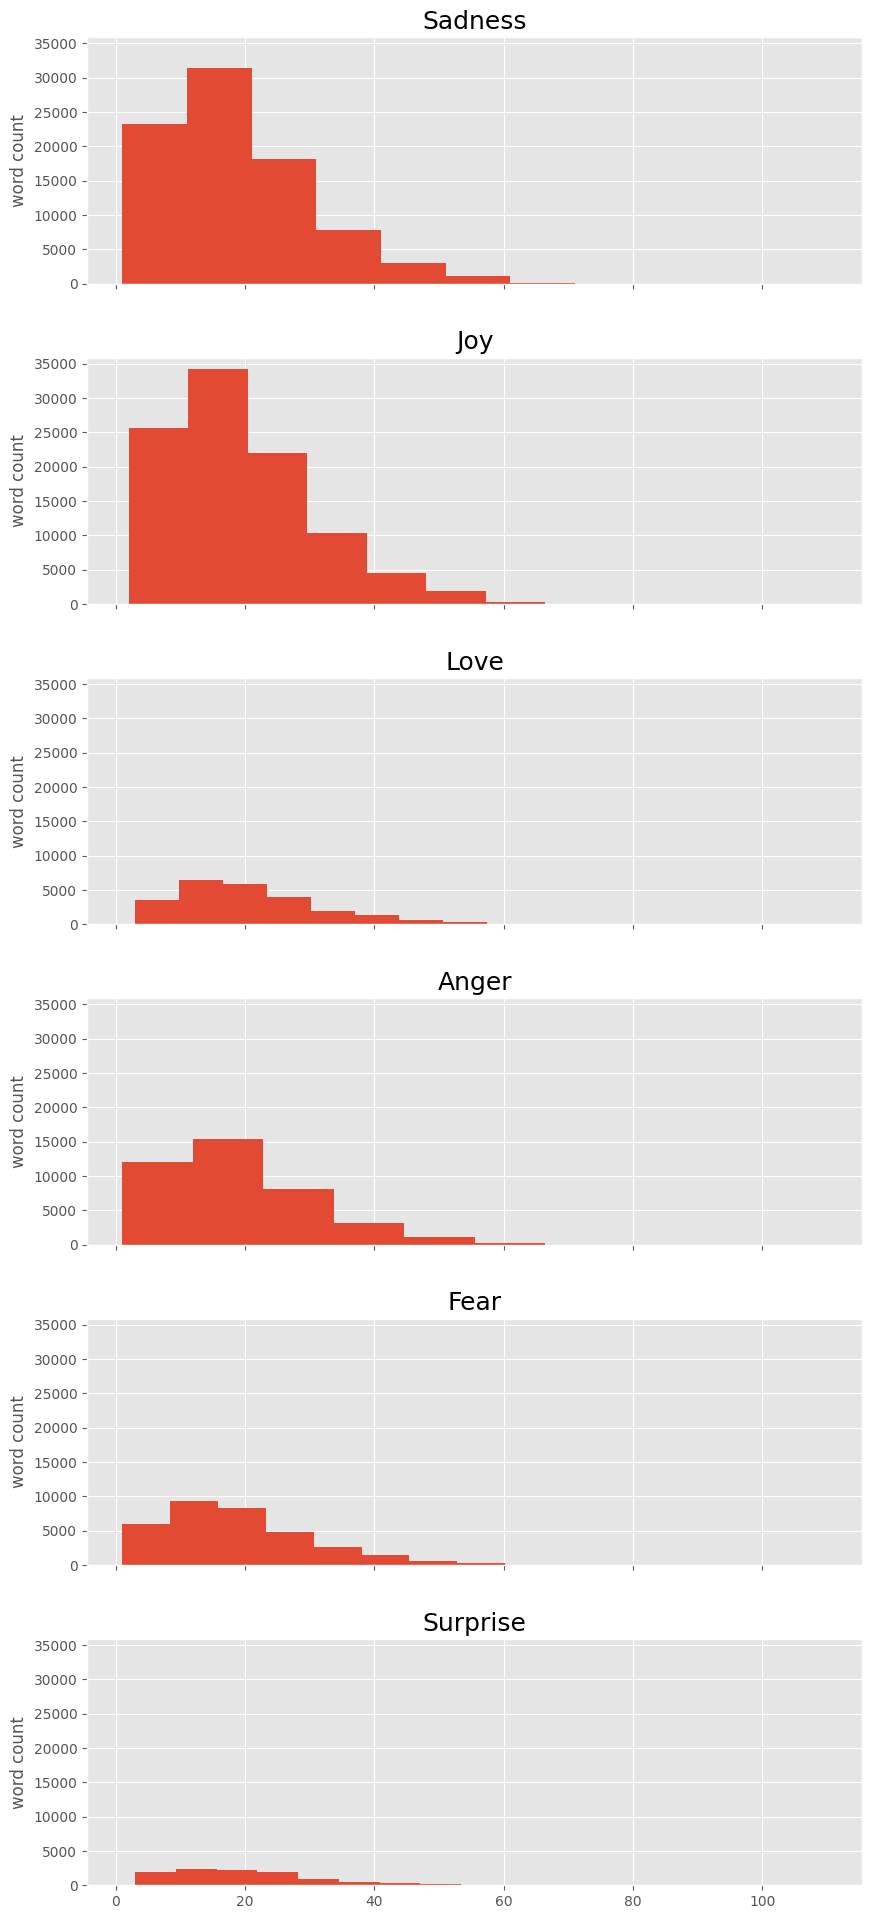

In [22]:
fig, ax = plt.subplots(nrows=6,ncols=1,figsize=(10,24), sharex=True, sharey=True)

i=0
for label, data_group in train_df.groupby('label'):
    print(f'Examples for {label_to_meaning[label]}:\n')
    
    for index,row in data_group.sample(n=3).iterrows():
        print(row['text'],'\n')
        
    print(f'there are {len(data_group)} samples')
    
    data_group['len']=data_group['text'].str.count(' ')+1
    data_group.hist(column='len',ax=ax[i],figsize=(10,4))
    print('\n\n\n')
    
    ax[i].set_title(label_to_meaning[label].capitalize(),fontsize=18)
    ax[i].set_ylabel('word count', fontsize='large')
    
    i+=1

In [23]:
train_df.groupby('label').count()/len(train_df)

,Unnamed: 0,text
label,,
0,0.290750,0.290750
1,0.338446,0.338446
2,0.082902,0.082902
3,0.137514,0.137514
4,0.114468,0.114468
5,0.035919,0.035919


In [24]:
train_df.groupby('label').count()

,Unnamed: 0,text
label,,
0,84831,84831
1,98747,98747
2,24188,24188
3,40122,40122
4,33398,33398
5,10480,10480


### 4.2- Vectorization <a class="anchor" id="Vectorization"/>

We create and train the vectorizer that will contain a dictionary of words to convert our text inputs to numbers. Note that usually stopwords are removed as they carry little value. However, I ommit this step to focus on data augmentation.

In [25]:
vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=None,
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    ngrams=None,
    output_mode='int',
    output_sequence_length=60,
    pad_to_max_tokens=False,
    vocabulary=None,
    idf_weights=None,
    sparse=False,
    ragged=False,
    encoding='utf-8',
    name=None)

vectorizer.adapt(train_df['text'].values)
# vectorizer.get_vocabulary()

In [26]:
print(f'There are {len(vectorizer.get_vocabulary())} words in the dictionary')

There are 63769 words in the dictionary


In [27]:
test=vectorizer(['my test sentence to make sure it is working as intended'])
test

<tf.Tensor: shape=(1, 60), dtype=int64, numpy=
array([[  11, 1431, 2890,    5,   89,  164,   13,   22,  340,   29, 2943,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0]])>

In [28]:
embedding=keras.layers.Embedding(input_dim=vectorizer.vocabulary_size()+1, output_dim=128)
embedding(test).shape

TensorShape([1, 60, 128])

# 5- Testing/Implementation <a class="anchor" id="testing"/>

In [29]:
def model_train(model, x_train, y_train, x_test, y_test, epochs=epochs,title='Model Accuracy'):

    start=time.time()
    model_hist = model.fit(x_train,y_train,epochs=epochs,validation_data=(x_test, y_test),verbose=1)
    end=time.time()

    train_time=end-start
    print(f"it took {train_time/60 if train_time>60 else train_time} {'min' if train_time>60 else 'sec'}")
    plt.plot(model_hist.history['accuracy'])
    plt.plot(model_hist.history['val_accuracy'])

    plt.title(title)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [30]:
model=keras.models.Sequential([
    keras.layers.Input(shape=(60,)),
    keras.layers.Embedding(input_dim=vectorizer.vocabulary_size()+1, output_dim=128),
    keras.layers.LSTM(128,return_sequences=True),
    keras.layers.Flatten(),
    keras.layers.Dense(60, activation='relu'),
    keras.layers.Dense(6)
])

model.compile(optimizer='adam',
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

### 5.1- No Augmentation <a class="anchor" id="noAug"/>

we train 1 epoch at a time to claculate F1 using scikit-learn F1 implementation.

epoch 1:

9118/9118 ━━━━━━━━━━━━━━━━━━━━ 83s 9ms/step - accuracy: 0.8681 - loss: 0.3225 - val_accuracy: 0.9369 - val_loss: 0.1006
3908/3908 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
9118/9118 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step



epoch 2:

9118/9118 ━━━━━━━━━━━━━━━━━━━━ 81s 9ms/step - accuracy: 0.9402 - loss: 0.0941 - val_accuracy: 0.9353 - val_loss: 0.1185
3908/3908 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
9118/9118 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step



epoch 3:

9118/9118 ━━━━━━━━━━━━━━━━━━━━ 81s 9ms/step - accuracy: 0.9434 - loss: 0.0865 - val_accuracy: 0.9394 - val_loss: 0.0941
3908/3908 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
9118/9118 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step



epoch 4:

9118/9118 ━━━━━━━━━━━━━━━━━━━━ 81s 9ms/step - accuracy: 0.9446 - loss: 0.0828 - val_accuracy: 0.9393 - val_loss: 0.0960
3908/3908 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
9118/9118 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step



epoch 5:

9118/9118 ━━━━━━━━━━━━━━━━━━━━ 81s 9ms/step - accuracy: 0.9438 - loss: 0.0811 - val_accuracy: 0.9394 - val_los

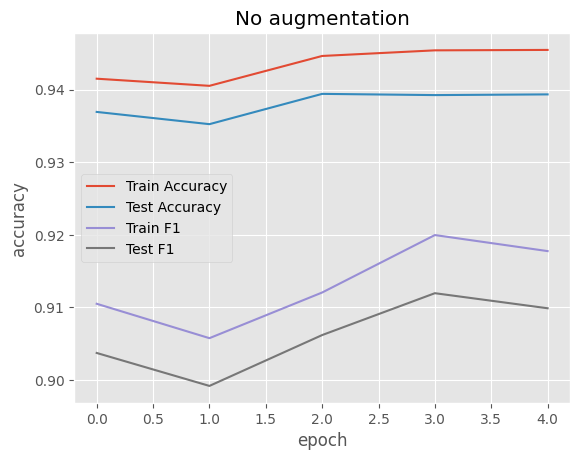

In [31]:
x_train=vectorizer(train_df['text'].values) 
y_train=train_df['label'].values
x_test=vectorizer(test_df['text'].values)
y_test=test_df['label'].values
y_true=y_test

accuracy_ls=[]
f1_ls=[]
train_acc_ls=[]
train_f1_ls=[]

if run_no_aug:
    for i in range(epochs):
        print(f'epoch {i+1}:\n')
        model_hist = model.fit(x_train,y_train,epochs=1,validation_data=(x_test, y_test),verbose=1)

        #test data
        y_pred=np.argmax(model.predict(x_test),axis=-1)
        y_train_pred=np.argmax(model.predict(x_train),axis=-1)

        acc_current=accuracy_score(y_true, y_pred)
        f1_current=f1_score(y_true, y_pred, average='macro')

        accuracy_ls.append(acc_current)
        f1_ls.append(f1_current)

        #train data
        acc_current=accuracy_score(y_train, y_train_pred)
        f1_current=f1_score(y_train, y_train_pred, average='macro')

        train_acc_ls.append(acc_current)
        train_f1_ls.append(f1_current)

        print('\n\n')

    plt.plot(train_acc_ls,label='Train Accuracy')
    plt.plot(accuracy_ls,label='Test Accuracy')

    plt.plot(train_f1_ls,label='Train F1')
    plt.plot(f1_ls,label='Test F1')

    plt.title('No augmentation')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')

    plt.legend()
    plt.show()


In [32]:
if run_no_aug: print(classification_report(y_true,y_pred,digits=4))

              precision    recall  f1-score   support

           0     0.9777    0.9724    0.9751     36356
           1     0.9851    0.9254    0.9543     42320
           2     0.7741    0.9956    0.8710     10366
           3     0.9058    0.9896    0.9459     17195
           4     0.9853    0.8104    0.8893     14314
           5     0.7653    0.8920    0.8238      4492

    accuracy                         0.9394    125043
   macro avg     0.8989    0.9309    0.9099    125043
weighted avg     0.9467    0.9394    0.9402    125043



In [33]:
if run_no_aug: f1_ls

In [34]:
if run_no_aug: accuracy_ls

### 5.2- With Augmentation <a class="anchor" id="WithAug"/>

In order to randomly apply data augmentation on a bacth as it enters the model, I will make a custom training loop.

- for each batch, I will randomly decide if we need to apply data augmentation.
- Apply data augmentation if selected.
- I will convert tokenize the words.

Implement the training loop according to tensorflow guide:

https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch

In [35]:
def random_batch(X:pd.DataFrame, y:pd.DataFrame, batch_size=32):
    idx = np.random.randint(len(X), size=batch_size)
    return X[idx], y[idx]

In [36]:
def print_status_bar(iteration, total, loss, metrics=None):
    metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result()) for m in [loss] + (metrics or [])])
    end = "" if iteration < total else "\n"
    print("\r{}/{} - ".format(iteration, total) + metrics,
    end=end)

Select the augmentations to apply

In [37]:
augmentation.keys()

dict_keys(['synonym', 'swap', 'delete', 'embedding_sub', 'embedding_insert', 'lan_sub', 'back-translation'])

In [38]:
model=keras.models.Sequential([
    keras.layers.Input(shape=(60,)),
    keras.layers.Embedding(input_dim=vectorizer.vocabulary_size()+1, output_dim=128),
    keras.layers.LSTM(128,return_sequences=True),
    keras.layers.Flatten(),
    keras.layers.Dense(60, activation='relu'),
    keras.layers.Dense(6)
])

Epoch 1/5
291766/291766 - mean: 0.4076 - mean_absolute_error: 0.0000
3908/3908 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step
9118/9118 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step
augmentations applied:
{'back-translation': 113, 'lan_sub': 478, 'delete': 105}

accuracy:  [0.9331749878041954]
F1:  [0.9006043531071586]



Epoch 2/5
291766/291766 - mean: 0.2602 - mean_absolute_error: 0.0000
3908/3908 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
9118/9118 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step
augmentations applied:
{'back-translation': 254, 'lan_sub': 892, 'delete': 200}

accuracy:  [0.9331749878041954, 0.9340067016946171]
F1:  [0.9006043531071586, 0.9002097433538566]



Epoch 3/5
291766/291766 - mean: 0.2589 - mean_absolute_error: 0.0000
3908/3908 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
9118/9118 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step
augmentations applied:
{'back-translation': 386, 'lan_sub': 1341, 'delete': 314}

accuracy:  [0.9331749878041954, 0.9340067016946171, 0.9332149740489272]
F1:  [0.9006043531071586, 0.9002097433538566, 0.895362

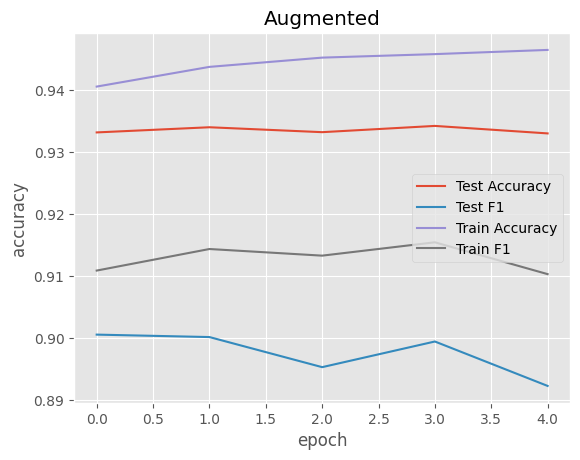

In [39]:
n_epochs = epochs
# batch_size = batch_size
n_steps = len(X_train) // batch_size
optimizer = keras.optimizers.Adam()
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
mean_loss = keras.metrics.Mean()
accuracy_metric=keras.metrics.Accuracy()
metrics = [keras.metrics.MeanAbsoluteError()]

# aug_keys=["synonym","lan_sub","back-translation","delete","swap"]

#back-translation should always be the first because i want either to do back-translation or other aug
# the items of the list are in the form (augmentation, probability of applying it)
aug_keys=[("lan_sub",0.8),("delete",0.2)]
aug_keys=[("back-translation",0.2)]+aug_keys

use_aug=True

X_train=train_df['text'].values
y_train=train_df['label'].values

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

x_test=test_df['text'].values 
y_test=test_df['label'].values

epochs_ls=[]
accuracy_train=[]
accuracy_test=[]

accuracy_ls=[]
f1_ls=[]
train_acc_ls=[]
train_f1_ls=[]

n_batch_aug={method:0 for method,_ in aug_keys}

if run_aug_batch:
    for epoch in range(1, n_epochs + 1):
        print("Epoch {}/{}".format(epoch, n_epochs))
    #     for step in range(1, n_steps + 1):
        for step, (X_batch, y_batch) in enumerate(train_dataset):

            #data augmentation
            if use_aug and np.random.rand()<aug_prob:
    #             print("AUGMENTATION")
                X_batch=X_batch.numpy().tolist()
                X_batch=list(map(lambda x: x.decode('utf-8'), X_batch))

                #apply data augmentation
                for key,prob in aug_keys:
                    # I will not apply all augmentations always.
                    if np.random.rand() < prob:
                        X_batch=augmentation[key].augment(X_batch)

                        n_batch_aug[key]=n_batch_aug[key]+1

                        # if back-translation was applied, then stop applying augmentations.
                        if key == 'back-translation':
                            break

    #         print("VECTORIZE")
            #tokenize the data
            X_batch=vectorizer(X_batch)

    #         print("GRADIENT")
            #Calculate the gradients
            with tf.GradientTape() as tape:
                y_pred = model(X_batch, training=True)
    #             main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                main_loss = loss_fn(y_batch, y_pred)
                loss = tf.add_n([main_loss] + model.losses)

    #         print("OPTIMIZE")
            #Optimize the model
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            mean_loss(loss)

    #         print("METRICS")
            y_pred = np.argmax(y_pred,axis=-1)

            accuracy_metric(y_batch, y_pred)

    #         for metric in metrics:
    #             metric(y_batch, y_pred)
    #         print_status_bar(step * batch_size, len(y_train), mean_loss, metrics)

        print_status_bar(len(y_train), len(y_train), mean_loss, metrics)
        mean_loss.reset_state()

        epochs_ls.append(epoch)
        accuracy_train.append(accuracy_metric.result())
        accuracy_metric.reset_state()

        y_pred = model.predict(vectorizer(x_test))
        y_pred = np.argmax(y_pred,axis=-1)

        accuracy_metric(y_test, y_pred)

        accuracy_test.append(accuracy_metric.result())
        accuracy_metric.reset_state()

        #test data
        y_train_pred=np.argmax(model.predict(vectorizer(X_train)),axis=-1)

        acc_current=accuracy_score(y_test, y_pred)
        f1_current=f1_score(y_test, y_pred, average='macro')

        accuracy_ls.append(acc_current)
        f1_ls.append(f1_current)

        #train data
        acc_current=accuracy_score(y_train, y_train_pred)
        f1_current=f1_score(y_train, y_train_pred, average='macro')

        train_acc_ls.append(acc_current)
        train_f1_ls.append(f1_current)

        print(f'augmentations applied:\n{n_batch_aug}\n')

        print("accuracy: ", accuracy_ls)
        print("F1: ", f1_ls)

        print('\n\n')

    plt.plot(accuracy_ls,label='Test Accuracy')
    plt.plot(f1_ls,label='Test F1')

    plt.plot(train_acc_ls,label='Train Accuracy')
    plt.plot(train_f1_ls,label='Train F1')

    plt.title('Augmented')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')

    plt.legend()
    plt.show()

In [40]:
if run_aug_batch: print(classification_report(y_test,y_pred,digits=4))

              precision    recall  f1-score   support

           0     0.9674    0.9708    0.9691     36356
           1     0.9299    0.9774    0.9531     42320
           2     0.9396    0.7330    0.8235     10366
           3     0.9497    0.9184    0.9338     17195
           4     0.8568    0.9386    0.8958     14314
           5     0.8638    0.7088    0.7787      4492

    accuracy                         0.9330    125043
   macro avg     0.9179    0.8745    0.8923    125043
weighted avg     0.9336    0.9330    0.9315    125043



### 5.3- Augment Minorities Only <a class="anchor" id="augMinority"/>

In [41]:
model=keras.models.Sequential([
    keras.layers.Input(shape=(60,)),
    keras.layers.Embedding(input_dim=vectorizer.vocabulary_size()+1, output_dim=128),
    keras.layers.LSTM(128,return_sequences=True),
    keras.layers.Flatten(),
    keras.layers.Dense(60, activation='relu'),
    keras.layers.Dense(6)
])

model.compile(optimizer='adam',
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

I will pick class 2 and 5 as they are the minorities and augment them and add the to train dataset

In [42]:
def apply_aug(sentence,aug_keys:list(tuple()),augmentation:dict):
    '''
    sentence is a list of str
    '''
    #apply data augmentation
    for key,prob in aug_keys:
        # I will not apply all augmentations always.
        if np.random.rand() < prob:
            sentence=augmentation[key].augment(sentence)

            # if back-translation was applied, then stop applying augmentations.
            if key == 'back-translation':
                break
                
    return sentence

In [43]:
if run_aug_min:
    minority_df=train_df[train_df['label'].isin([2,5])]
#     mid_df=train_df[train_df['label'].isin([3,4])]

#     minority_df = pd.DataFrame(np.repeat(minority_df.values, 2, axis=0), columns=minority_df.columns)
#     mid_df = pd.DataFrame(np.repeat(mid_df.values, 2, axis=0), columns=mid_df.columns)

#     augmented_df=pd.concat([minority_df,mid_df])

    n_groups=len(minority_df)//64#batch size of 64
    
    minority_df['group']=np.random.randint(0,n_groups,size=len(minority_df))
    
    augmented_df=minority_df.copy()
    
    print(f'there are {len(augmented_df)} augmented samples')
    
    augmented_df.head()

we cannot train using all the data. I will randomly pick enough datapoint to balance the original dataset.

In [44]:
# if run_aug_min:
#     X=augmented_df.index.values.tolist()
#     y=augmented_df['label'].values.tolist()
#     train_size=80000
#     X_aug, _, y_aug, _=train_test_split(X, y, train_size=train_size, random_state=random_state, stratify=y)

In [45]:
# if run_aug_min: aug_df=augmented_df.loc[X_aug]

In [46]:
if run_aug_min:
    # aug_keys=["synonym", "lan_sub", "embedding_insert", "back-translation", "delete", "swap"]

    #back-translation should always be the first because i want either to do back-translation or other aug
    # the items of the list are in the form (augmentation, probability of applying it)
    aug_keys=[("lan_sub",0.4),("delete",0.2),("swap",0.2)]
    aug_keys=[("back-translation",0.2)]+aug_keys

    print("started augmentation")
#     augmented_df['text']=augmented_df['text'].apply(lambda sentence: apply_aug(sentence,aug_keys,augmentation))

    aug_df=pd.DataFrame(columns=augmented_df.columns)
    
    for group_index, group_df in augmented_df.groupby(['group']):
        group_df['text']=apply_aug(group_df['text'].tolist(),aug_keys,augmentation)
        
        aug_df=pd.concat([aug_df,group_df])
    
    augmented_df=aug_df
    print("finished augmenting")
    
    augmented_df

In [47]:
if run_aug_min: train_df=pd.concat([train_df,augmented_df]).reset_index(drop=True)

In [48]:
if run_aug_min: train_df

In [49]:
x_train=vectorizer(train_df['text'].values) 
y_train=train_df['label'].values
x_test=vectorizer(test_df['text'].values)
y_test=test_df['label'].values
y_true=y_test

accuracy_ls=[]
f1_ls=[]
train_acc_ls=[]
train_f1_ls=[]

if run_aug_min:
    for i in range(epochs):
        print(f'epoch {i+1}:\n')
        model_hist = model.fit(x_train,y_train,epochs=1,validation_data=(x_test, y_test),verbose=1)

        #test data
        y_pred=np.argmax(model.predict(x_test),axis=-1)
        y_train_pred=np.argmax(model.predict(x_train),axis=-1)

        acc_current=accuracy_score(y_true, y_pred)
        f1_current=f1_score(y_true, y_pred, average='macro')

        accuracy_ls.append(acc_current)
        f1_ls.append(f1_current)

        #train data
        acc_current=accuracy_score(y_train, y_train_pred)
        f1_current=f1_score(y_train, y_train_pred, average='macro')

        train_acc_ls.append(acc_current)
        train_f1_ls.append(f1_current)

        print('\n\n')

    plt.plot(train_acc_ls,label='Train Accuracy')
    plt.plot(accuracy_ls,label='Test Accuracy')

    plt.plot(train_f1_ls,label='Train F1')
    plt.plot(f1_ls,label='Test F1')

    plt.title('No augmentation')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')

    plt.legend()
    plt.show()

In [50]:
if run_aug_min: print(classification_report(y_true,y_pred,digits=4))

In [51]:
if run_aug_min: f1_ls

In [52]:
if run_aug_min: accuracy_ls

# 6- Conclusion <a class="anchor" id="conclusion"/>

This notebook shows that it is not easy to use data augmentation for NLP. The reasons:
- The increase in training time is huge. The augmentation techniques use language models for augmentation which increase training time. Moreover, we vectorize the data at every batch instead of just once.

- No performance boost. As we can see the performance was lower than without data augmentation. The reason is that it requires further investigations on what augmentations to apply and to which words. For example, see the results to check which words are mistakenly attributed to a class. Maybe the word sad only appears in sentences which are sad. Then, whenever the model sees the word sad, it classifies to that class. Therefore, adding data augmentation to those word specifically, may enhance performance.

- Not easy to implement. Unlike, computer vision, we need to augment text before we can vectorize, and we need to vectorize before we can pass the data through the model. Thus, we needed to implement a custom training loop. Alternatively, we can augment the minority classes only and the trainning becomes similar to "No Augmnetation" section.